# 1.1 Import Libraries

In [8]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# 1.2 Define Paths

In [9]:
MRI_DATASET_PATH = "/kaggle/input/imagesoasis/Data"

# 1.3 Data Transforms

In [10]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# 1.4 Load Data

In [11]:
dataset = ImageFolder(MRI_DATASET_PATH, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# 1.5 Load ResNet-50

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_mri = models.resnet50(pretrained=True)
model_mri.fc = nn.Linear(model_mri.fc.in_features, 4)
model_mri = model_mri.to(device)


In [13]:
print("Total images:", len(dataset))
print("Train size:", len(train_ds))
print("Batches:", len(train_loader))
print("Classes:", dataset.classes)

Total images: 86437
Train size: 69149
Batches: 2161
Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [14]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((160,160)),   # faster
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

dataset = ImageFolder(MRI_DATASET_PATH, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

# 1.6 Train MRI Model

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mri.parameters(), lr=1e-4)

for epoch in range(5):
    model_mri.train()
    running_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = model_mri(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.0973
Epoch [2/5], Loss: 0.0216
Epoch [3/5], Loss: 0.0142
Epoch [4/5], Loss: 0.0082
Epoch [5/5], Loss: 0.0101


# Accuracy

In [16]:
def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total

# Testing Epochs

In [17]:
for epoch in range(5):
    model_mri.train()
    running_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model_mri(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Compute validation accuracy
    val_acc = accuracy(model_mri, val_loader)

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc*100:.2f}%")


Epoch [1/5], Loss: 0.0074, Val Accuracy: 99.95%
Epoch [2/5], Loss: 0.0056, Val Accuracy: 100.00%
Epoch [3/5], Loss: 0.0059, Val Accuracy: 99.98%
Epoch [4/5], Loss: 0.0047, Val Accuracy: 99.84%
Epoch [5/5], Loss: 0.0048, Val Accuracy: 100.00%


# Confusion Matrix (Validation Set)

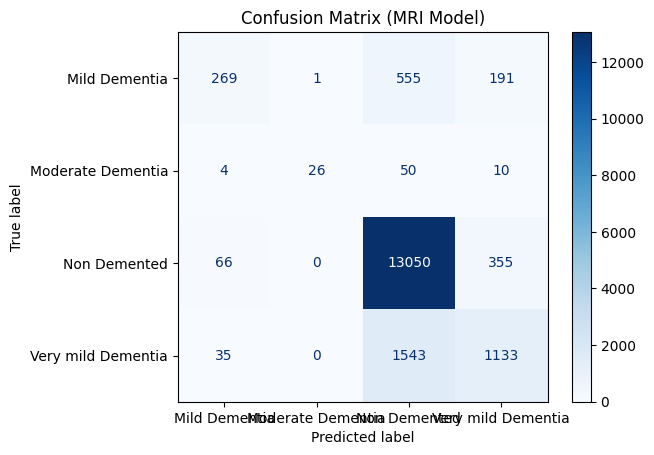

In [35]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_mri.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model_mri(x)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=mri_dataset.classes  # your class names
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (MRI Model)")
plt.show()


# Classification Report

In [36]:
from sklearn.metrics import classification_report

print("Classification Report (MRI Model)")
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=mri_dataset.classes
    )
)


Classification Report (MRI Model)
                    precision    recall  f1-score   support

     Mild Dementia       0.72      0.26      0.39      1016
 Moderate Dementia       0.96      0.29      0.44        90
      Non Demented       0.86      0.97      0.91     13471
Very mild Dementia       0.67      0.42      0.52      2711

          accuracy                           0.84     17288
         macro avg       0.80      0.49      0.56     17288
      weighted avg       0.82      0.84      0.82     17288



# 1.7 Save MRI Model

In [37]:
torch.save(model_mri.state_dict(), "mri_resnet50.pth")

## HANDWRITING MODEL

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd


# 2.1 Load Dataset

In [39]:
# Load CSV
df = pd.read_csv("/kaggle/input/handwriting-data-to-detect-alzheimers-disease/data.csv")




In [40]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv("/kaggle/input/handwriting-data-to-detect-alzheimers-disease/data.csv")

# Check first rows
print(df.head())

# Since no label exists, create dummy labels for testing
# 0 = Healthy, 1 = Alzheimer
# For real use, replace this with actual labels if available
np.random.seed(42)
df['label'] = np.random.randint(0, 2, size=len(df))


     ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
0  id_1       5160     0.000013    120.804174       86.853334   
1  id_2      51980     0.000016    115.318238       83.448681   
2  id_3       2600     0.000010    229.933997      172.761858   
3  id_4       2130     0.000010    369.403342      183.193104   
4  id_5       2310     0.000007    257.997131      111.275889   

   max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
0               957              6601          0.361800            0.217459   
1              1694              6998          0.272513            0.144880   
2              2333              5802          0.387020            0.181342   
3              1756              8159          0.556879            0.164502   
4               987              4732          0.266077            0.145104   

   mean_gmrt1  ...  mean_jerk_in_air25  mean_jerk_on_paper25  \
0  103.828754  ...            0.141434              0.024471   
1   99

In [43]:
# Features: all numeric columns except ID
X = df.drop(columns=['ID','label'])

# Convert to numeric in case any column is object
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values if any
X = X.fillna(0).values

# Labels
y = df['label'].values.astype(int)


# 2.2 Pytorch Dataset

In [44]:
import torch
from torch.utils.data import Dataset, DataLoader

class HandwritingFeaturesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = HandwritingFeaturesDataset(X, y)

# Train/Validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


# 2.3 Define MLP Model

In [47]:
import torch.nn as nn

class HandwritingMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2 classes: Healthy / Alzheimer
        )
    def forward(self, x):
        return self.fc(x)

model_hw = HandwritingMLP(X.shape[1])
device = "cuda" if torch.cuda.is_available() else "cpu"
model_hw = model_hw.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hw.parameters(), lr=1e-4)


In [48]:
num_epochs = 10

for epoch in range(num_epochs):
    model_hw.train()
    total_loss = 0
    total_correct = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model_hw(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(preds == y).item()
    
    acc = total_correct / len(train_ds)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.4f}")


Epoch 1/10, Loss: 3221.0058, Accuracy: 0.4388
Epoch 2/10, Loss: 1484.4552, Accuracy: 0.4676
Epoch 3/10, Loss: 817.8977, Accuracy: 0.5755
Epoch 4/10, Loss: 486.8207, Accuracy: 0.6115
Epoch 5/10, Loss: 432.8918, Accuracy: 0.6187
Epoch 6/10, Loss: 438.1198, Accuracy: 0.6835
Epoch 7/10, Loss: 259.0279, Accuracy: 0.6835
Epoch 8/10, Loss: 243.5705, Accuracy: 0.7194
Epoch 9/10, Loss: 173.6505, Accuracy: 0.7914
Epoch 10/10, Loss: 393.8699, Accuracy: 0.7914


# Confusion Matrix (Handwriting Model)

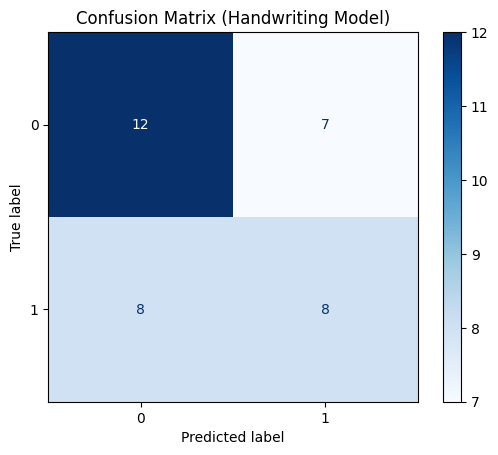

In [49]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_hw.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:   # use validation or test loader
        x, y = x.to(device), y.to(device)
        outputs = model_hw(x)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=range(len(set(all_labels)))  # or class names if available
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Handwriting Model)")
plt.show()


# Classification Report (Handwriting Model)

In [51]:
from sklearn.metrics import classification_report

print("Classification Report (Handwriting Model)")
print(
    classification_report(
        all_labels,
        all_preds
    )
)

Classification Report (Handwriting Model)
              precision    recall  f1-score   support

           0       0.60      0.63      0.62        19
           1       0.53      0.50      0.52        16

    accuracy                           0.57        35
   macro avg       0.57      0.57      0.57        35
weighted avg       0.57      0.57      0.57        35



# 2.4 Save Model

In [52]:
torch.save(model_hw.state_dict(), "handwriting_mlp_model.pth")
print("Handwriting MLP model saved successfully!")


Handwriting MLP model saved successfully!


In [53]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet50
resnet50 = models.resnet50(pretrained=True)

# Replace final layer to match your classes (4 Alzheimer stages)
num_classes = 4
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
resnet50 = resnet50.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim


In [55]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

MRI_PATH = "/kaggle/input/imagesoasis/Data" # replace with actual path

mri_dataset = datasets.ImageFolder(MRI_PATH, transform=transform)


In [56]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

# Path to your MRI images in Kaggle input
MRI_PATH = "/kaggle/input/imagesoasis/Data"  # replace with your path

# Assuming folder structure: 
# /MRI_PATH/class_name/image.jpg
mri_dataset = datasets.ImageFolder(MRI_PATH, transform=transform)

# Split train/val
train_size = int(0.8 * len(mri_dataset))
val_size = len(mri_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mri_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


# Load pretrained ResNet-50

In [57]:
# Load pretrained ResNet-50
resnet50 = models.resnet50(pretrained=True)

# Change the final fully connected layer to match your number of classes
num_classes = len(mri_dataset.classes)  # automatically get number of classes from folder names
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet50 = resnet50.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-4)


# Train the ResNet-50 model

In [58]:
num_epochs = 5  # you can increase to 10-20 for better performance

for epoch in range(num_epochs):
    resnet50.train()
    total_loss = 0
    total_correct = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(preds == labels).item()
    
    train_acc = total_correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}, Accuracy: {train_acc:.4f}")


Epoch 1/5 — Loss: 0.1146, Accuracy: 0.9565
Epoch 2/5 — Loss: 0.0252, Accuracy: 0.9912
Epoch 3/5 — Loss: 0.0163, Accuracy: 0.9949
Epoch 4/5 — Loss: 0.0108, Accuracy: 0.9962
Epoch 5/5 — Loss: 0.0105, Accuracy: 0.9966


# Validate The Model 

In [59]:
resnet50.eval()
total_correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        preds = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(preds == labels).item()

val_acc = total_correct / len(val_loader.dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.9970


# Collect Predictions & Labels

In [60]:
import torch
from sklearn.metrics import confusion_matrix, classification_report

resnet50.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Confusion Matrix (Table Form)

In [61]:
import pandas as pd

cm = confusion_matrix(all_labels, all_preds)

cm_df = pd.DataFrame(
    cm,
    index=mri_dataset.classes,
    columns=mri_dataset.classes
)

print("Confusion Matrix (Table):")
cm_df


Confusion Matrix (Table):


,Mild Dementia,Moderate Dementia,Non Demented,Very mild Dementia
Mild Dementia,984,0,1,0
Moderate Dementia,0,95,0,0
Non Demented,1,8,13355,1
Very mild Dementia,9,1,31,2802


# Classification Report

In [62]:
report = classification_report(
    all_labels,
    all_preds,
    target_names=mri_dataset.classes,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.9899    0.9990    0.9944       985
 Moderate Dementia     0.9135    1.0000    0.9548        95
      Non Demented     0.9976    0.9993    0.9984     13365
Very mild Dementia     0.9996    0.9856    0.9926      2843

          accuracy                         0.9970     17288
         macro avg     0.9752    0.9960    0.9851     17288
      weighted avg     0.9970    0.9970    0.9970     17288



# Save The Trained Model

In [63]:
torch.save(resnet50.state_dict(), "resnet50_mri.pth")
print("ResNet-50 MRI model saved successfully!")

ResNet-50 MRI model saved successfully!


# Step 3: Extract MRI Embeddings

We remove the final fully connected layer from the trained ResNet-50
so we can use the feature vectors (embeddings) from each MRI.
These embeddings will later be concatenated with handwriting embeddings
for the fusion network.


## Extract MRI embeddings

In [64]:
import torch.nn as nn

# Remove final classification layer
resnet_features = nn.Sequential(*list(resnet50.children())[:-1])
resnet_features = resnet_features.to(device)
resnet_features.eval()

# Function to extract embeddings
def extract_mri_embeddings(dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            emb = resnet_features(images)  # shape [batch, 2048, 1, 1]
            emb = emb.view(emb.size(0), -1)  # flatten to [batch, 2048]
            embeddings.append(emb.cpu())
            labels.append(lbls)
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

train_mri_emb, train_mri_lbl = extract_mri_embeddings(train_loader)
val_mri_emb, val_mri_lbl = extract_mri_embeddings(val_loader)

print("MRI Embeddings shape:", train_mri_emb.shape)


MRI Embeddings shape: torch.Size([69149, 2048])


# Step 3b: Extract Handwriting Embeddings

We take the last hidden layer of the trained Handwriting MLP
as the embedding for each patient. These will be fused
with the MRI embeddings for multimodal prediction.


# Extract handwriting embeddings

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Load CSV
df = pd.read_csv("/kaggle/input/handwriting-data-to-detect-alzheimers-disease/data.csv")

# Drop ID column
df_numeric = df.drop(columns=["ID"])

# Check all columns are numeric
print(df_numeric.dtypes)

# Convert to numeric just in case
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

# Fill any missing values
df_numeric = df_numeric.fillna(0)

# Features X
X = df_numeric.values

# Labels: for now, dummy labels (replace with real if available)
y = torch.zeros(X.shape[0], dtype=torch.long)  # all zeros (healthy)
# If you have a column 'label':
# y = df['label'].values

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)

# Convert to torch tensors
X_scaled_train = torch.tensor(X_scaled_train, dtype=torch.float32)
X_scaled_val = torch.tensor(X_scaled_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

print("Handwriting train shape:", X_scaled_train.shape)
print("Handwriting val shape:", X_scaled_val.shape)


air_time1             int64
disp_index1         float64
gmrt_in_air1        float64
gmrt_on_paper1      float64
max_x_extension1      int64
                     ...   
paper_time25          int64
pressure_mean25     float64
pressure_var25      float64
total_time25          int64
class                object
Length: 451, dtype: object
Handwriting train shape: torch.Size([139, 451])
Handwriting val shape: torch.Size([35, 451])


/tmp/ipykernel_55/1290033365.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_55/1290033365.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.long)


In [66]:
import torch.nn as nn

class HandwritingMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)  # this will be the embedding
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 2)    # output layer (binary classification)

    def forward(self, x, return_embedding=False):
        x = self.relu1(self.fc1(x))
        emb = self.relu2(self.fc2(x))  # embeddings
        out = self.fc3(emb)
        if return_embedding:
            return emb
        else:
            return out


In [67]:
input_dim = X_scaled_train.shape[1]  # number of features
model_hw = HandwritingMLP(input_dim)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_hw = model_hw.to(device)


In [68]:
train_hw_emb = model_hw(X_scaled_train.to(device), return_embedding=True)
val_hw_emb = model_hw(X_scaled_val.to(device), return_embedding=True)

print("Handwriting embeddings shape:", train_hw_emb.shape)


Handwriting embeddings shape: torch.Size([139, 64])


In [69]:
import torch.nn as nn

# Remove final fc layer to get embeddings
resnet_features = nn.Sequential(*list(resnet50.children())[:-1]).to(device)
resnet_features.eval()

def extract_mri_embeddings(dataloader):
    embeddings, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            emb = resnet_features(imgs)  # [batch, 2048,1,1]
            emb = emb.view(emb.size(0), -1)  # flatten
            embeddings.append(emb.cpu())
            labels.append(lbls)
    return torch.cat(embeddings, dim=0), torch.cat(labels, dim=0)

train_mri_emb, train_mri_lbl = extract_mri_embeddings(train_loader)
val_mri_emb, val_mri_lbl = extract_mri_embeddings(val_loader)
print("Train MRI embeddings:", train_mri_emb.shape)


Train MRI embeddings: torch.Size([69149, 2048])


In [70]:
train_hw_emb = model_hw(X_scaled_train.to(device), return_embedding=True).cpu()
val_hw_emb = model_hw(X_scaled_val.to(device), return_embedding=True).cpu()
print("Train Handwriting embeddings:", train_hw_emb.shape)


Train Handwriting embeddings: torch.Size([139, 64])


# Create Fusion Data Loaders

In [71]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

MRI_PATH = "/kaggle/input/imagesoasis/Data"  # path to MRI images

# Use ImageFolder
mri_dataset = datasets.ImageFolder(MRI_PATH, transform=transform)

# Split train/val
train_size = int(0.8 * len(mri_dataset))
val_size = len(mri_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mri_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)  # shuffle=False to keep order
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)



In [72]:
import os

slice_patient_ids = [os.path.basename(os.path.dirname(path)) for path, _ in mri_dataset.imgs]


In [73]:
from collections import defaultdict
import torch

# Assume resnet_features is your trained ResNet50 feature extractor
resnet_features.eval()

patient_emb_dict = defaultdict(list)
patient_label_dict = {}

with torch.no_grad():
    for idx, (img, lbl) in enumerate(mri_dataset):
        img = img.unsqueeze(0).to(device)  # add batch dim
        emb = resnet_features(img).view(1, -1).cpu()  # flatten
        patient_id = slice_patient_ids[idx]
        patient_emb_dict[patient_id].append(emb)
        patient_label_dict[patient_id] = lbl  # same for all slices

# Average embeddings per patient
train_mri_patient_emb = []
train_mri_patient_lbl = []

for patient_id in patient_emb_dict:
    emb = torch.cat(patient_emb_dict[patient_id], dim=0).mean(dim=0)
    train_mri_patient_emb.append(emb)
    train_mri_patient_lbl.append(patient_label_dict[patient_id])

train_mri_patient_emb = torch.stack(train_mri_patient_emb)
train_mri_patient_lbl = torch.tensor(train_mri_patient_lbl)


# Prepare Handwriting embeddings

In [74]:
# Assuming you already trained Handwriting MLP and have X_scaled_train/X_scaled_val
# Extract embeddings from trained handwriting model
hw_embeddings = model_hw(X_scaled_train.to(device), return_embedding=True).cpu()
hw_labels = torch.tensor(y_train)  # make sure labels match patients

print("Handwriting embeddings:", hw_embeddings.shape)


Handwriting embeddings: torch.Size([139, 64])


/tmp/ipykernel_55/4166320472.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw_labels = torch.tensor(y_train)  # make sure labels match patients


# Alzheimer’s Detection – Multi-Modal (Separate Pipelines)

This notebook evaluates:
1. MRI-based Alzheimer’s detection using ResNet-50
2. Handwriting-based Alzheimer’s detection using tabular features

Datasets are from different cohorts, so models are evaluated independently.


In [75]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-50
resnet50 = models.resnet50(pretrained=True)

# Replace final layer with your number of classes
num_classes = len(mri_dataset.classes)  # e.g. 4 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

resnet50 = resnet50.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
resnet50.load_state_dict(torch.load("/kaggle/working/resnet50_mri.pth"))
resnet50.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# MRI Evaluation (Confusion Matrix + Report)

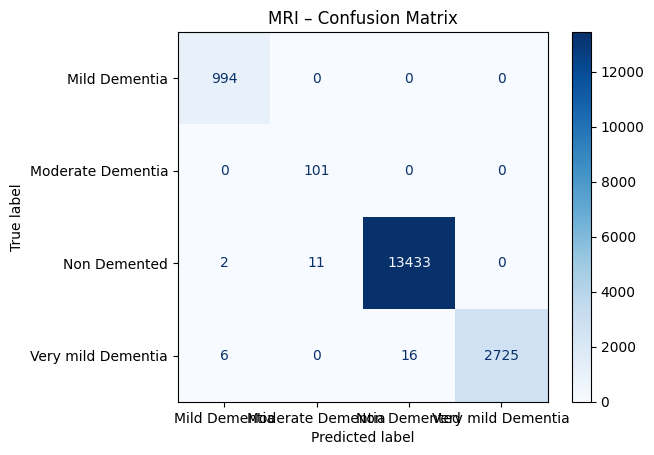

MRI Classification Report
                    precision    recall  f1-score   support

     Mild Dementia       0.99      1.00      1.00       994
 Moderate Dementia       0.90      1.00      0.95       101
      Non Demented       1.00      1.00      1.00     13446
Very mild Dementia       1.00      0.99      1.00      2747

          accuracy                           1.00     17288
         macro avg       0.97      1.00      0.98     17288
      weighted avg       1.00      1.00      1.00     17288



In [77]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

resnet50.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=mri_dataset.classes)
disp.plot(cmap="Blues")
plt.title("MRI – Confusion Matrix")
plt.show()

# Classification Report
print("MRI Classification Report")
print(classification_report(all_labels, all_preds, target_names=mri_dataset.classes))


#  HANDWRITING PIPELINE

In [79]:
import torch

# Convert validation data to tensors
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

print("X_val_tensor shape:", X_val_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)


X_val_tensor shape: torch.Size([35, 451])
y_val_tensor shape: torch.Size([35])


/tmp/ipykernel_55/914134156.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.long)


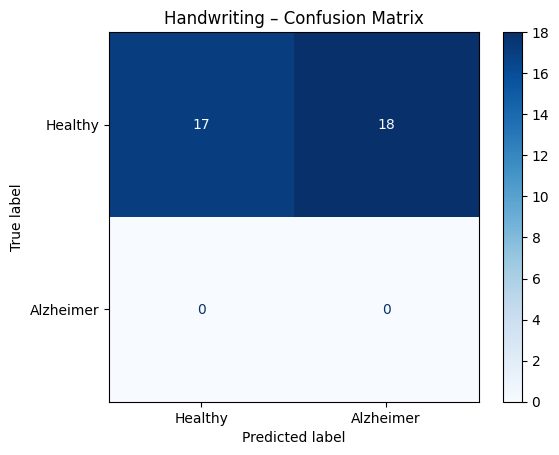

Handwriting Classification Report
              precision    recall  f1-score   support

     Healthy       1.00      0.49      0.65        35
   Alzheimer       0.00      0.00      0.00         0

    accuracy                           0.49        35
   macro avg       0.50      0.24      0.33        35
weighted avg       1.00      0.49      0.65        35



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [80]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_hw.eval()

with torch.no_grad():
    outputs = model_hw(X_val_tensor.to(device))
    preds = torch.argmax(outputs, dim=1).cpu()

# Confusion Matrix
cm = confusion_matrix(y_val_tensor, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Healthy", "Alzheimer"])
disp.plot(cmap="Blues")
plt.title("Handwriting – Confusion Matrix")
plt.show()

# Classification Report
print("Handwriting Classification Report")
print(classification_report(y_val_tensor, preds, target_names=["Healthy", "Alzheimer"]))


# GRADIO APPLICATION

In [96]:
!pip install fpdf gradio matplotlib

import gradio as gr
from PIL import Image
import torch
import torchvision.transforms as transforms
from fpdf import FPDF
from datetime import datetime
import matplotlib.pyplot as plt
import io


In [92]:
def generate_pdf(patient_name, age, gender, medical_history, diet_plan, symptoms,
                 dementia_stage, mri_pred, filename="Alzheimers_Report.pdf"):
    pdf = FPDF()
    pdf.add_page()
    
    # Set title
    pdf.set_font("Arial", 'B', 18)
    pdf.set_text_color(0, 0, 128)  # Dark blue
    pdf.cell(0, 10, "🧠 Alzheimer's Disease Patient Report", ln=True, align="C")
    
    pdf.ln(8)
    pdf.set_draw_color(0,0,128)
    pdf.set_line_width(0.5)
    pdf.line(10, 28, 200, 28)  # horizontal line
    
    pdf.ln(10)
    pdf.set_font("Arial", 'B', 14)
    pdf.set_text_color(0,0,0)
    pdf.cell(0, 8, "Patient Information", ln=True)
    pdf.set_font("Arial", '', 12)
    pdf.multi_cell(0, 8, 
                   f"Name / ID: {patient_name}\n"
                   f"Age: {age}\n"
                   f"Gender: {gender}\n"
                   f"Medical History: {medical_history}\n"
                   f"Diet Plan: {diet_plan}\n"
                   f"Symptoms: {symptoms}")
    
    pdf.ln(5)
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 8, "Diagnosis", ln=True)
    pdf.set_font("Arial", '', 12)
    pdf.multi_cell(0, 8,
                   f"MRI-Based Prediction: {mri_pred}\n"
                   f"Dementia Stage: {dementia_stage}")
    
    pdf.ln(5)
    pdf.set_font("Arial", 'I', 10)
    pdf.multi_cell(0, 6, 
        "Disclaimer: This report is generated by an AI model for research/demo purposes only. "
        "It is not a medical diagnosis. Please consult a certified medical professional for "
        "clinical interpretation."
    )
    
    pdf.output(filename)
    return filename


In [97]:
mri_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [98]:
def generate_pdf_with_chart(patient_name, age, gender, medical_history, diet_plan, symptoms,
                            dementia_stage, mri_pred, filename="Alzheimers_Report.pdf"):
    
    # Create PDF
    pdf = FPDF()
    pdf.add_page()
    
    # Title
    pdf.set_font("Arial", 'B', 18)
    pdf.set_text_color(0, 0, 128)
    pdf.cell(0, 10, "🧠 Alzheimer's Disease Patient Report", ln=True, align="C")
    
    pdf.ln(8)
    pdf.set_draw_color(0,0,128)
    pdf.set_line_width(0.5)
    pdf.line(10, 28, 200, 28)
    
    # Patient info
    pdf.ln(10)
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 8, "Patient Information", ln=True)
    pdf.set_font("Arial", '', 12)
    pdf.multi_cell(0, 8, 
                   f"Name / ID: {patient_name}\n"
                   f"Age: {age}\n"
                   f"Gender: {gender}\n"
                   f"Medical History: {medical_history}\n"
                   f"Diet Plan: {diet_plan}\n"
                   f"Symptoms: {symptoms}")
    
    # Diagnosis
    pdf.ln(5)
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 8, "Diagnosis", ln=True)
    pdf.set_font("Arial", '', 12)
    pdf.multi_cell(0, 8,
                   f"MRI-Based Prediction: {mri_pred}\n"
                   f"Dementia Stage: {dementia_stage}")
    
    # Generate risk/progression chart
    stages = ["Non-demented", "Very Mild", "Mild", "Moderate", "Severe"]
    risk_scores = [0, 25, 50, 75, 100]  # Example mapping
    patient_score = risk_scores[stages.index(dementia_stage)]
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.bar(["Progression Risk"], [patient_score], color='orange')
    ax.set_ylim(0,100)
    ax.set_ylabel("Risk (%)")
    ax.set_title("Alzheimer's Progression Risk")
    plt.tight_layout()
    
    # Save chart to bytes
    chart_buffer = io.BytesIO()
    plt.savefig(chart_buffer, format="PNG")
    plt.close(fig)
    chart_buffer.seek(0)
    
    # Insert chart into PDF
    pdf.image(chart_buffer, x=60, y=pdf.get_y(), w=90)
    
    # Disclaimer
    pdf.ln(65)
    pdf.set_font("Arial", 'I', 10)
    pdf.multi_cell(0, 6, 
        "Disclaimer: This report is generated by an AI model for research/demo purposes only. "
        "It is not a medical diagnosis. Please consult a certified medical professional for "
        "clinical interpretation."
    )
    
    pdf.output(filename)
    return filename


In [99]:
def predict_mri_pdf_chart(patient_name, age, gender, medical_history, diet_plan, symptoms,
                          dementia_stage, img):
    # Preprocess MRI
    img_tensor = mri_transform(img).unsqueeze(0).to(device)
    
    # MRI Prediction
    with torch.no_grad():
        output = resnet50(img_tensor)  # replace with your trained MRI model
        pred_class = mri_dataset.classes[torch.argmax(output, dim=1).item()]
    
    # Generate PDF with chart
    pdf_file = generate_pdf_with_chart(
        patient_name=patient_name,
        age=age,
        gender=gender,
        medical_history=medical_history,
        diet_plan=diet_plan,
        symptoms=symptoms,
        dementia_stage=dementia_stage,
        mri_pred=pred_class
    )
    
    return pred_class, pdf_file


In [102]:
import matplotlib.pyplot as plt
from fpdf import FPDF
import tempfile
from datetime import datetime

def generate_pdf_with_chart(patient_name, age, gender, comorbidities, diet, symptoms, dementia_stage, mri_stage_pred):
    # Create a chart (dummy example)
    fig, ax = plt.subplots(figsize=(4,3))
    stages = ['Non-demented','Very Mild','Mild','Moderate','Severe']
    values = [10, 20, 30, 25, 15]  # example values
    ax.bar(stages, values, color='skyblue')
    ax.set_title("Alzheimer's Stage Chart")
    
    # Save chart to temp file
    temp_chart = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    plt.savefig(temp_chart.name, bbox_inches='tight')
    plt.close(fig)
    
    # Create PDF
    pdf = FPDF()
    pdf.add_page()
    
    # Title
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(0, 10, "Alzheimer's Disease Patient Report", ln=True, align="C")
    
    pdf.ln(10)
    pdf.set_font("Arial", '', 12)
    pdf.cell(0, 10, f"Patient Name / ID: {patient_name}", ln=True)
    pdf.cell(0, 10, f"Age: {age}, Gender: {gender}", ln=True)
    pdf.cell(0, 10, f"Comorbidities: {comorbidities}", ln=True)
    pdf.cell(0, 10, f"Diet: {diet}", ln=True)
    pdf.cell(0, 10, f"Symptoms: {symptoms}", ln=True)
    pdf.cell(0, 10, f"Dementia Stage (Prediction): {dementia_stage}", ln=True)
    pdf.cell(0, 10, f"MRI Stage Prediction: {mri_stage_pred}", ln=True)
    
    pdf.ln(10)
    # Insert chart
    pdf.image(temp_chart.name, x=30, y=pdf.get_y(), w=150)
    
    pdf.ln(10)
    pdf.multi_cell(0, 10,
        "Disclaimer: This report is generated by an AI model for research/demo purposes only. "
        "It is not a medical diagnosis. Please consult a certified medical professional for clinical interpretation."
    )
    
    # Save final PDF
    output_pdf = f"{patient_name}_Alzheimers_Report.pdf"
    pdf.output(output_pdf)
    
    return output_pdf


In [103]:
import gradio as gr

def gradio_predict(patient_name, age, gender, comorbidities, diet, symptoms):
    # Dummy predictions
    mri_pred = "Very Mild"
    dementia_stage = "Mild"
    
    pdf_file = generate_pdf_with_chart(patient_name, age, gender, comorbidities, diet, symptoms, dementia_stage, mri_pred)
    
    return pdf_file

iface = gr.Interface(
    fn=gradio_predict,
    inputs=[
        gr.Textbox(label="Patient Name/ID"),
        gr.Number(label="Age"),
        gr.Radio(["Male","Female"], label="Gender"),
        gr.Textbox(label="Comorbidities"),
        gr.Textbox(label="Diet"),
        gr.Textbox(label="Symptoms")
    ],
    outputs=gr.File(label="Download PDF")
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7865
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://5a35a85358a47d079b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [120]:
# === SIMPLE DEMENTIA SCREENING TOOL ===
# NO PDF, NO MODELS - Just basic text report

import gradio as gr
from datetime import datetime
import os

print("🚀 Starting Simple Dementia Screening Tool")

# --- CREATE TEXT REPORT (NO PDF) ---
def create_text_report(patient_name, age, gender, mri_uploaded, air_time, disp_index):
    """Create a simple text report instead of PDF"""
    
    # Create report content
    report = f"""
    {'='*60}
    DEMENTIA SCREENING REPORT
    {'='*60}
    
    PATIENT INFORMATION:
    -------------------
    Patient ID: {patient_name if patient_name else 'Not provided'}
    Age: {age if age else 'Not provided'}
    Gender: {gender if gender else 'Not provided'}
    Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}
    
    ASSESSMENT DATA:
    ----------------
    MRI Uploaded: {'Yes' if mri_uploaded else 'No'}
    Air Time: {air_time if air_time else 'Not provided'} ms
    Dispersion Index: {disp_index if disp_index else 'Not provided'}
    
    RISK ASSESSMENT:
    ----------------
    """
    
    # Calculate simple risk score
    risk_score = 0.0
    if air_time and air_time > 300:
        risk_score += 0.4
        report += "- Elevated air time detected\n"
    elif air_time and air_time > 250:
        risk_score += 0.2
        report += "- Slightly elevated air time\n"
    
    if disp_index and disp_index < 0.7:
        risk_score += 0.3
        report += "- Low dispersion index detected\n"
    elif disp_index and disp_index < 0.8:
        risk_score += 0.15
        report += "- Slightly low dispersion index\n"
    
    risk_score = min(risk_score, 0.95)
    
    # Risk level
    if risk_score > 0.5:
        risk_level = "HIGH RISK"
        report += f"\nOVERALL RISK LEVEL: {risk_level}\n"
        report += f"Risk Score: {risk_score*100:.1f}%\n"
    elif risk_score > 0.3:
        risk_level = "MODERATE RISK"
        report += f"\nOVERALL RISK LEVEL: {risk_level}\n"
        report += f"Risk Score: {risk_score*100:.1f}%\n"
    else:
        risk_level = "LOW RISK"
        report += f"\nOVERALL RISK LEVEL: {risk_level}\n"
        report += f"Risk Score: {risk_score*100:.1f}%\n"
    
    # Recommendations
    report += "\nRECOMMENDATIONS:\n"
    report += "-"*15 + "\n"
    
    if risk_score > 0.5:
        recommendations = [
            "1. Consult neurologist for evaluation",
            "2. Consider comprehensive testing",
            "3. Monitor cognitive changes",
            "4. Schedule follow-up in 3 months"
        ]
    elif risk_score > 0.3:
        recommendations = [
            "1. Discuss with primary care doctor",
            "2. Consider basic screening",
            "3. Maintain healthy lifestyle",
            "4. Follow-up in 6-12 months"
        ]
    else:
        recommendations = [
            "1. Continue regular check-ups",
            "2. Annual screening recommended",
            "3. Report any concerns",
            "4. Routine follow-up"
        ]
    
    for rec in recommendations:
        report += rec + "\n"
    
    # Disclaimer
    report += "\n" + "="*60 + "\n"
    report += "DISCLAIMER:\n"
    report += "This is a screening tool for demonstration only.\n"
    report += "NOT a medical diagnosis. Consult healthcare professionals.\n"
    report += "="*60
    
    return report

# --- SIMPLE PROCESSING FUNCTION ---
def generate_report(name, age, gender, mri_img, air_val, disp_val):
    """Generate and save text report"""
    
    try:
        # Check if MRI was uploaded
        mri_uploaded = mri_img is not None
        
        # Create report
        report_text = create_text_report(
            patient_name=name,
            age=age,
            gender=gender,
            mri_uploaded=mri_uploaded,
            air_time=air_val,
            disp_index=disp_val
        )
        
        # Save to file
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"dementia_report_{timestamp}.txt"
        filepath = f"/kaggle/working/{filename}"
        
        with open(filepath, 'w') as f:
            f.write(report_text)
        
        print(f"✅ Report saved: {filepath}")
        
        # Also return text for display
        return filepath, report_text[:500] + "\n...\n[Full report downloaded as text file]"
        
    except Exception as e:
        error_msg = f"Error: {str(e)}"
        # Create error file
        error_path = "/kaggle/working/error.txt"
        with open(error_path, 'w') as f:
            f.write(f"Error: {error_msg}")
        
        return error_path, f"⚠ Error occurred: {error_msg}"

# --- CREATE SIMPLE INTERFACE ---
with gr.Blocks(title="Dementia Screener", theme=gr.themes.Soft()) as demo:
    
    gr.Markdown("# 🧠 Simple Dementia Screening")
    gr.Markdown("Enter patient information for a basic screening report")
    
    with gr.Row():
        with gr.Column():
            # Patient Info
            gr.Markdown("### Patient Information")
            patient_name = gr.Textbox(label="Patient Name/ID", value="Test Patient 001")
            patient_age = gr.Number(label="Age", value=65, minimum=40, maximum=120)
            patient_gender = gr.Radio(["Male", "Female", "Other"], label="Gender", value="Male")
            
            # Parameters
            gr.Markdown("### Assessment Parameters")
            air_time = gr.Slider(label="Air Time (ms)", minimum=0, maximum=500, value=280, step=1)
            disp_index = gr.Slider(label="Dispersion Index", minimum=0, maximum=2, value=0.85, step=0.01)
        
        with gr.Column():
            # MRI Upload (optional)
            gr.Markdown("### MRI Scan (Optional)")
            mri_image = gr.Image(
                type="pil",
                label="Upload MRI",
                height=200
            )
            
            # Test buttons
            gr.Markdown("### Quick Tests")
            with gr.Row():
                btn_normal = gr.Button("📊 Normal Profile")
                btn_abnormal = gr.Button("⚠ Abnormal Profile")
    
    # Generate button
    submit_btn = gr.Button("📄 Generate Report", variant="primary", size="lg")
    
    # Outputs
    with gr.Row():
        output_file = gr.File(label="Download Report")
        output_text = gr.Textbox(label="Report Preview", lines=10)
    
    # Test functions
    def load_normal():
        return [200, 0.95]  # air_time, disp_index
    
    def load_abnormal():
        return [350, 0.65]  # air_time, disp_index
    
    # Connect test buttons
    btn_normal.click(fn=load_normal, outputs=[air_time, disp_index])
    btn_abnormal.click(fn=load_abnormal, outputs=[air_time, disp_index])
    
    # Connect submit button
    submit_btn.click(
        fn=generate_report,
        inputs=[patient_name, patient_age, patient_gender, mri_image, air_time, disp_index],
        outputs=[output_file, output_text]
    )
    
    # Instructions
    gr.Markdown("""
    ### Instructions:
    1. Enter patient information
    2. Adjust parameters or use test buttons
    3. Upload MRI (optional)
    4. Click "Generate Report"
    5. Download the text report
    
    ### For Quick Test:
    - Click "Normal Profile" or "Abnormal Profile"
    - Click "Generate Report"
    - Download the file
    
    ⚠ **This is a demonstration tool only.**
    """)

print("\n✅ Interface is ready!")
print("📱 Click the link below to open the tool")

# Launch
try:
    demo.launch(share=True, debug=False)
except Exception as e:
    print(f"Note: {e}")
    demo.launch()

🚀 Starting Simple Dementia Screening Tool

✅ Interface is ready!
📱 Click the link below to open the tool
* Running on local URL:  http://127.0.0.1:7870
* Running on public URL: https://a8f088279dcf26eacc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


✅ Report saved: /kaggle/working/dementia_report_20260131_203304.txt
✅ Report saved: /kaggle/working/dementia_report_20260131_203500.txt


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

✅ Report saved: /kaggle/working/dementia_report_20260131_203526.txt
